In [1]:
import os, sys

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

# 1. Data

In [5]:
# where we will store the data
input_texts = []
target_texts = []
target_texts_inputs = []

In [6]:
t = 0
for line in open('./kor.txt', encoding='utf-8'):
    t += 1
    
    # keeping limited number of samples because of saving time.
    if t > NUM_SAMPLES:
        break
    
    if '\t' not in line:
        continue
    
    # each sequence needs to be the same length.
    input_text, translation = line.rstrip().split('\t')
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("num samples: ", len(input_texts))    

num samples:  799


In [7]:
input_texts[2], target_texts[2], target_texts_inputs[2]

('No way!', '절대 아니야. <eos>', '<sos> 절대 아니야.')

# 2. Preprocesssing

In [8]:
# tokenize the inputs - english
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)

# transform
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [9]:
# {word: sequence}
word2idx_inputs = tokenizer_inputs.word_index
print("Found %s unique input tokens." % len(word2idx_inputs))

Found 1062 unique input tokens.


In [10]:
# max_length
max_len_input = max(len(s) for s in input_sequences)
max_len_input

19

In [11]:
# tokenize the outputs - korean

# don't fitler out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequncess_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [12]:
word2idx_outputs = tokenizer_outputs.word_index
print("Found %s unique output tokens." % len(word2idx_outputs))

Found 1826 unique output tokens.


- index가 0부터가 아니라 1부터 주어진다.

In [13]:
# store number of output words for later
# remeber to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [14]:
max_len_target

16

In [15]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape: ", encoder_inputs.shape)
print("encoder_data[0]: ", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequncess_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]: ", decoder_inputs[0])
print("decoder_Data.shape: ", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape:  (799, 19)
encoder_data[0]:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 79]
decoder_data[0]:  [  2 438   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
decoder_Data.shape:  (799, 16)


## 3. Model

### 1. embedding

In [16]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [17]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


### 2. target

In [18]:
# create targets, since we cannot use sparse
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### 3. model

In [19]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [20]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True, # we only need last lstm output state
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

In [21]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

In [22]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [23]:
# Create the model object
# teacher forcing
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 19, 100)      106300      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 16, 256)      467712      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [24]:
# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Train on 639 samples, validate on 160 samples
Epoch 1/100
639/639 [==============================] - 3s 5ms/step - loss: 3.7174 - acc: 0.6503 - val_loss: 3.4322 - val_acc: 0.5574
Epoch 2/100
639/639 [==============================] - 1s 1ms/step - loss: 1.7978 - acc: 0.7317 - val_loss: 3.3090 - val_acc: 0.5719
Epoch 3/100
639/639 [==============================] - 1s 1ms/step - loss: 1.7519 - acc: 0.7361 - val_loss: 3.5171 - val_acc: 0.5684
Epoch 4/100
639/639 [==============================] - 1s 1ms/step - loss: 1.6772 - acc: 0.7495 - val_loss: 3.6531 - val_acc: 0.5703
Epoch 5/100
639/639 [==============================] - 1s 1ms/step - loss: 1.6190 - acc: 0.7613 - val_loss: 3.5496 - val_acc: 0.5777
Epoch 6/100
639/639 [==============================] - 1s 1ms/step - loss: 1.5705 - acc: 0.7720 - val_loss: 3.5337 - val_acc: 0.6047
Epoch 7/100
639/639 [==============================] - 1s 1ms/step - loss: 1.5179 - acc: 0.7881 - val_loss: 3.7472 - val_acc: 0.5840
Epoch 8/100
639/639 [==

Epoch 62/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0524 - acc: 0.9866 - val_loss: 4.7234 - val_acc: 0.6203
Epoch 63/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0498 - acc: 0.9869 - val_loss: 4.7438 - val_acc: 0.6141
Epoch 64/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0462 - acc: 0.9867 - val_loss: 4.7397 - val_acc: 0.6141
Epoch 65/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0434 - acc: 0.9877 - val_loss: 4.7272 - val_acc: 0.6176
Epoch 66/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0410 - acc: 0.9868 - val_loss: 4.7466 - val_acc: 0.6191
Epoch 67/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0386 - acc: 0.9877 - val_loss: 4.7491 - val_acc: 0.6172
Epoch 68/100
639/639 [==============================] - 1s 1ms/step - loss: 0.0363 - acc: 0.9868 - val_loss: 4.7669 - val_acc: 0.6168
Epoch 69/100
639/639 [==============================] - 1s 1ms

In [25]:
decoder_targets_one_hot.shape

(799, 16, 1827)

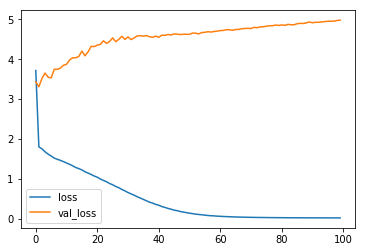

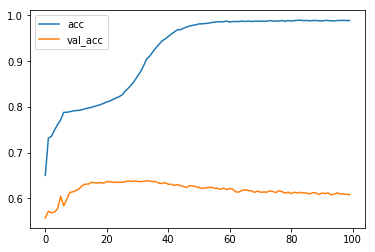

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [26]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')

# 4. Prediction

In [27]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
# 출력이 한개다.
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

In [28]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 19, 100)           106300    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 365568    
Total params: 471,868
Trainable params: 471,868
Non-trainable params: 0
_________________________________________________________________


In [29]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             467712      input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_2 (LS

In [30]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # Create the translation
    output_sentence = []
    
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value
        )
        # output_tokens, h = decoder_model.predict(
        #     [target_seq] + states_value
        # ) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
    
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)


In [32]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input: After driving for eight hours, Tom just couldn't drive any longer.
Translation: 그는 두 시간 동안 더 걸었다.
Continue? [Y/n]y
-
Input: Do you want to take a walk?
Translation: 산책하고 싶어?
Continue? [Y/n]y
-
Input: They're amateurs.
Translation: 걔네 초짜야.
Continue? [Y/n]y
-
Input: This house is not for sale.
Translation: 이 집은 팔려고 내놓은 집 아니에요.
Continue? [Y/n]y
-
Input: Remember that we're all in the same boat.
Translation: 우리는 다 같은 처지에 있지 않는다.
Continue? [Y/n]y
-
Input: I don't buy it.
Translation: 못 믿어.
Continue? [Y/n]y
-
Input: Don't pry into my private life.
Translation: 내 사생활 캐묻지 마.
Continue? [Y/n]y
-
Input: We can't give up.
Translation: 포기할 수 없어요.
Continue? [Y/n]y
-
Input: Let's meet in front of the theater.
Translation: 극장 앞에서 만납시다.
Continue? [Y/n]y
-
Input: You need to accept your role.
Translation: 넌 너의 역할을 받아들일 필요가 있어.
Continue? [Y/n]y
-
Input: Keep Tom there.
Translation: 톰은 여기에 두세요.
Continue? [Y/n]y
-
Input: Drive carefully.
Translation: 운전 조심해.
Continue? [Y/n]y
-
Input: You look tire